# Auditing Allocative Bias
In this blogpost, I will train a model to predict income based on demographic variables *excluding* sex, and perform audit for gender bias on the model.

## Data Preparation
The data I choose to look into is the PUMS data in for Illinois in 2019. 

In [2]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "IL"

data_source = ACSDataSource(survey_year='2019', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)
possible_features=['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR', "PINCP"]
acs_data[possible_features].head()

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR,PINCP
0,19,19.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0,0.0
1,18,18.0,5,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,6.0,800.0
2,22,16.0,5,2,NaN,1,3.0,1.0,2,1,2,2,2.0,1,1,4.0,35000.0
3,64,16.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0,0.0
4,53,16.0,5,2,NaN,5,1.0,4.0,1,2,2,2,2.0,1,1,1.0,31200.0


I would like to predict whether an individual's income is over $50K based on all the variables in <code>possible_features</code> except for sex. I will create a feature matrix, a label vector, and a group label vector using the relevant variables, and split them into training data and test data.

In [3]:
features_to_use = [f for f in possible_features if f not in ["PINCP", "SEX"]]

IncomeProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: (x > 50000) * 1, # transform income variable into binary category
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = IncomeProblem.df_to_numpy(acs_data)

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

### Basic Descriptives
Before training any models, I will first explore the basic descriptives of the dataset. 

In [4]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

In [5]:
size = len(df)
size

100005

There are 100005 individuals in the dataset. 

In [6]:
(df["label"] == 1).sum()/size

0.25900704964751764

Around 25.9% of these individuals earn over $50K. 

In [7]:
df.groupby("group").size()

group
1    49135
2    50870
dtype: int64

49,135 of the individuals in the dataset are male and 50,870 are female.

In [8]:
df.groupby("group")["label"].mean().reset_index()


,group,label
0,1,0.326712
1,2,0.193611


Around 32.7% of male individuals in the dataset has income over 50k dollars, but only 19.4% of women has income over $50k. 

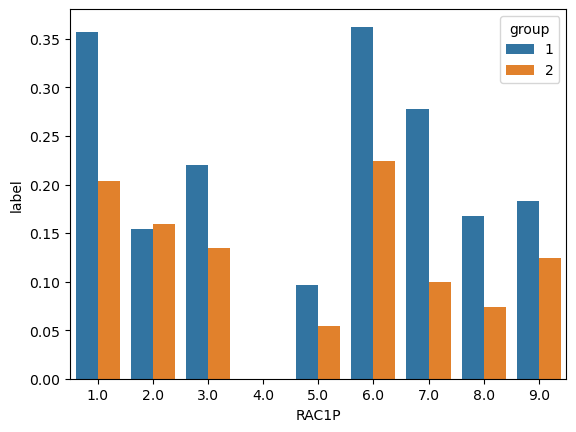

In [9]:
import seaborn as sns
proportions = df.groupby(["group", "RAC1P"])["label"].mean().reset_index()
ax = sns.barplot(data = proportions, x = "RAC1P", y = "label", hue = "group")

It seems that for almost all race groups, the proportion of men with income over $50k is greater than that of women. The only exception is African Americans, for whom this proportion doesn't differ very much across sex. 

## Training the model
I choose to use a decision tree classifier for my prediction. I will use cross-validation to find out the best max depth for the model. 

Best cv score =  0.8124193790310483
Best max depth =  8


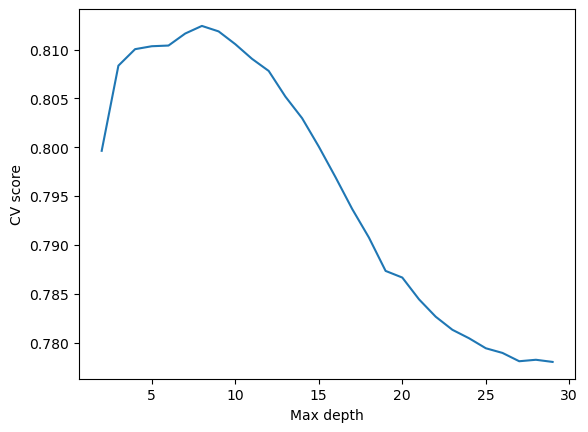

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cv_max = 0
best_depth = 0
cvs = []

for d in range(2, 30):
    # fit model
    DTC = DecisionTreeClassifier(max_depth = d)
    DTC.fit(X_train, y_train)

    # cross-validation
    cv_scores = cross_val_score(DTC, X_train, y_train, cv = 5)
    cv_mean = cv_scores.mean()
    cvs.append(cv_mean)

    # update best cv score and best degree
    if cv_mean > cv_max:
        cv_max = cv_mean
        best_depth = d

print("Best cv score = ", cv_max)
print("Best max depth = ", best_depth)

# draw a line chart for cv scores at varying degrees
import matplotlib.pyplot as plt
fig = plt.plot(range(2, 30), cvs)
xlab = plt.xlabel("Max depth")
ylab = plt.ylabel("CV score")

As shown by the graph, the best performance is reached at a max depth of 8. 

## Auditing the Model
Next, I will use the model on the test data and perform an audit for bias.

In [12]:
# train model and predict using test data
DTC = DecisionTreeClassifier(max_depth = best_depth)
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)

### Overall Measures
First, we will take a look at the measures for the whole dataset. 

In [13]:
from sklearn.metrics import confusion_matrix

# get confusion matrix values
cm = confusion_matrix(y_test, y_pred)
TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

test_score = DTC.score(X_test, y_test)
PPV = TP / (TP + FP)
FNR = FN / (TP + FN)
FPR = FP / (TN + FP)

print("Overall accuracy = ", test_score)
print("PPV = ", PPV)
print("FNR = ", FNR)
print("FPR = ", FPR)

Overall accuracy =  0.8154547636189104
PPV =  0.9172221027735971
FNR =  0.15264673751117291
FPR =  0.31661184210526316


The overall accuracy and PPV show that the model is quite accurate. The FPR is one time higher than the FPR, suggesting that this model is more likely to wrongly predict that someone earns over $50K when they does not in reality, compared to wrongly predict that someone earns less than 50K. 

### By-Group Measures
Then we will compute the same measures by each group (i.e., male and female) and see if there are any differences. 

In [15]:
male = group_test == 1
female = group_test == 2

correct = (y_test == y_pred)

accuracy_male = correct[male].mean()
accuracy_female = correct[female].mean()

accuracy_male, accuracy_female

(0.7848350566223535, 0.8445692883895131)

The accuracy for male and female is similar, and a little higher for female. 

In [16]:
#X_test_df = pd.DataFrame(X_test, columns = [features_to_use])
cm_male = confusion_matrix(y_test[male],y_pred[male])
cm_female = confusion_matrix(y_test[female],y_pred[female])

# male
TP, FP, FN, TN = cm_male[0][0], cm_male[0][1], cm_male[1][0], cm_male[1][1]
PPV_male = TP / (TP + FP)
FNR_male = FN / (TP + FN)
FPR_male = FP / (TN + FP)

# female
TP, FP, FN, TN = cm_female[0][0], cm_female[0][1], cm_female[1][0], cm_female[1][1]
PPV_female = TP / (TP + FP)
FNR_female = FN / (TP + FN)
FPR_female = FP / (TN + FP)

PPV_male, PPV_female

(0.9251758428328887, 0.9108901332303534)

The PPV for male and female is similar too. 

In [17]:
FNR_male, FNR_female

(0.20811708532281503, 0.10177075399847677)

The false negative rate is higher for male than for female. This shows that if a man earns more than $50K, the model is more likely to make a mistake and say he earns less, compared to the same situation for a woman. 

In [18]:
FPR_male, FPR_female

(0.24177115987460815, 0.3992214532871972)

The false positive rate is higher for female than for male. This means that the model is more likely to predict that a woman earns more than $50K when she actually earns less. 

### Bias Measures
Finally, we will calculate the three different bias measures discussed by Chouldechova (2017). 

The first measure is **calibration**. Good calibration means that a man and a woman who received the same score (in this case, either 0 or 1) have the same probability of earning over $50K. 

In [19]:
# Calibration
print("% positive for male predicted positive = ", y_test[male][y_pred[male] == 1].mean())
print("% positive for female predicted positive = ", y_test[female][y_pred[female] == 1].mean())
print("% positive for male predicted negative = ", y_test[male][y_pred[male] == 0].mean())
print("% positive for female predicted negative = ", y_test[female][y_pred[female] == 0].mean())

% positive for male predicted positive =  0.7582288401253918
% positive for female predicted positive =  0.6007785467128027
% positive for male predicted negative =  0.20811708532281503
% positive for female predicted negative =  0.10177075399847677


The probabilities are around 0.1-0.15 higher for men than for women. It looks like the model is roughly calibrated, but still, there is a slight difference in what the same score means for the two groups. 

Next we will look at **error rate balance**. According to Chouldechova (2017), a score satisfies error rate balance at a threshold $S_{HR}$ if the FPR and FNR are both equal across groups. Because our model only have binary scores, this would just mean that the FPR and FNR are equal across gender. 

In [21]:
FPR_male, FPR_female

(0.24177115987460815, 0.3992214532871972)

In [20]:
FNR_male, FNR_female

(0.20811708532281503, 0.10177075399847677)

From the FPR and FNR that we calculated in the last section, we can see that the model doesn't have error rate balance. The FPR is higher for women and the FNR is higher for men. 

Our last measure is **statistical parity**. This is satisfied if the proportion of individuals classified as positive is the same for each group.

In [22]:
TP, FP, FN, TN = cm_male[0][0], cm_male[0][1], cm_male[1][0], cm_male[1][1]
PR_male = (TP+FP) / (TP+FP+TN+FN)
TP, FP, FN, TN = cm_female[0][0], cm_female[0][1], cm_female[1][0], cm_female[1][1]
PR_female = (TP+FP) / (TP+FP+TN+FN)

PR_male, PR_female

(0.6766781552601345, 0.8082084893882646)

This model doesn't have statistical parity -- the proportion of women classified as earning over $50K is higher than that of men. 

## Concluding Discussion
With a system like what I have built in this blogpost, companies will be able to identify high-income individuals based on a set of demographics data. This would especially benefit companies that sell high-end products by enabling them to locate their target group of consumers. 

The main takeaway from my bias audit is that this model tends to overestimate the income of a woman and underestimate the income of a man. If the model is deployed in a large-scale setting, it would mean that more women will be incorrectly identified as marketing targets for certain products. Moreover, in the case that companies make use of predicted income for discriminatory pricing across income groups, more women will be harmed by this act. 

I think that this model exhibits bias in all forms that I have measured. In terms of calibration, men who received positive labels were more likely to be positive than women who received positive labels. Looking at the error rates, we also see that false positive rates are higher for women and false negative rates are higher for men. For statistical parity, we see a similar pattern where higher proportions of women than men were classified as positive. All of these measures reflect more or less the same theme. 

I find it interesting and unsettling that just like the recidivism prediction model that we discussed in class, the bias of this model is also potentially an artifact of inequalities present in the real world. Given a man and a woman who are similar in features other than sex, the model would predict that they have similar levels of income. In reality, however, women with similar qualifications as men are often paid less as a result of structural discrimination that is not captured by the dataset. This explains why the model tends to classify women as earning more than they do in reality. 

Another problem beyond bias is that whether it is ethical at all to use any model that predicts income. Even if the model is accurate and relatively unbiased, it is hard to see how such a model would benefit the individuals upon which it is used. The government may need income information for social welfare programs, but it doesn't need to use a model to acquire such information. As for companies, I would imagine that the main motivation for predicting income is to maximize profit by discriminately charging income groups. 